# Završni rad - Predviđanje starosti korištenjem neuronskih mreža (dio 2/2)

U ovoj bilježnici testiran je rad naših modela, implementiranih u prvom dijelu, na konkretnim slikama. Preporuča se prvo pogledati taj dio pošto su u njemu detaljnija objašnjenja korištenih modela i funkcija. 

Modeli su testirani na 1 proizvoljnoj slici koja u sebi sadrži lice osobe. Idealno bi bilo da lice osobe centrirano, poravnato i da prekriva većinu slike pošto smo na takvim slikama učili naše modele. \
Također bitno je da u nazivu slike imamo označeno koliko godina osoba ima na slici. U implementaciji je obrađen samo slučaj kada je naziv slike oblika nekiBroj_godinaRodenja_nekiBroj-nekiBroj_godinaSlikanja npr. 23006_1974-04-28_2011.

Konačni rezultati prikazani su na samom kraju bilježnice. 

## 0. Importi 

In [1]:
import numpy as np              
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle
import os                       
import cv2                      
from PIL import Image
from collections import Counter
import time
import shutil
#!pip install pandas
import pandas as pd
from pathlib import Path
#!pip install sklearn
from sklearn.model_selection import train_test_split
#!pip install tensorflow
import tensorflow as tf
from sklearn.metrics import r2_score
import keras

from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import SeparableConv2D
from keras.layers import MaxPool2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import LayerNormalization
from keras.layers import Dropout
from keras.models import Sequential  
from keras.callbacks import ReduceLROnPlateau 
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomContrast
from tensorflow.keras.layers import RandomBrightness

import json
import tempfile

## 1. Učitavanje željenih modela 

Modeli su već spremljeni na disk u prethodnoj bilježnici.

In [2]:
reg_weights_path = Path('/Users/ninaanic/Tehnicke/6_semestar/ZavRad/main/jupyter notebooks/reg_weights.h5')
reg_config_path = Path('/Users/ninaanic/Tehnicke/6_semestar/ZavRad/main/jupyter notebooks/reg_config.json')
clf_weights_path = Path('/Users/ninaanic/Tehnicke/6_semestar/ZavRad/main/jupyter notebooks/clf_weights.h5')
clf_config_path = Path('/Users/ninaanic/Tehnicke/6_semestar/ZavRad/main/jupyter notebooks/clf_config.json')

def load_model(weights_path, config_path):
    # loadanje modela iz configa
    with open(config_path, 'r') as f:
        model_json = json.load(f)
    model = tf.keras.models.model_from_json(model_json)
    
    # ucitavanje tezina
    model.load_weights(weights_path, by_name=True)
    
    return model

#load_model(weights_path, config_path)

## 2. Učitavanje slike 

Putanju odabrane slike koju želimo testirati predajemo u varijablu _img_path_. \
Sliku skaliramo na dimenzije 1x200x200x3 te prikazujemo.

(262, 262)


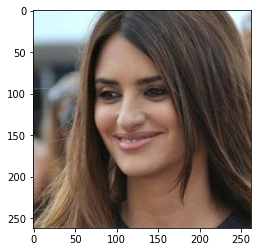

(200, 200)


/var/folders/xs/x1qjkybs4711f5nr19v2bzsh0000gn/T/ipykernel_23623/4026865909.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = imgOG.resize((200, 200), Image.ANTIALIAS)


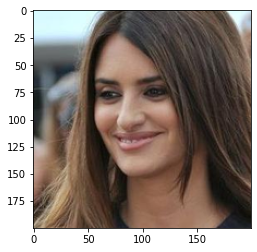

(200, 200, 3)
(1, 200, 200, 3)


In [3]:
img_path = Path('/Users/ninaanic/Tehnicke/6_semestar/ZavRad/main/datasets/slike/23006_1974-04-28_2011.jpg')
imgOG = Image.open(img_path)
print(imgOG.size)
plt.imshow(imgOG)
plt.show()

img = imgOG.resize((200, 200), Image.ANTIALIAS)
print(img.size)
plt.imshow(img)
plt.show()

img = np.array(img)
print(img.shape)

img = np.reshape(img, (1,200,200,3))
print(img.shape)

## 3. Priprema seta

Ovaj dio je jednak kao u prvoj bilježnici samo što ovdje računanje populacijskih statistika radimo na jednoj slici (_img_) a ne na skupu slika. 

In [4]:
rgb_mean, rgb_stddev = None, None

if rgb_mean is None:
    print('calculating mean on img...')
    rgb_mean = img.mean(axis=(0,1,2))
    
if rgb_stddev is None:
    print('calculating stddev on img...')
    rgb_stddev = img.std(axis=(0,1,2))

print(f'train_mean: {rgb_mean}')
print(f'train_stddev: {rgb_stddev}')

calculating mean on img...
calculating stddev on img...
train_mean: [107.8949   90.6772   80.48995]
train_stddev: [54.02897282 52.53505401 52.70860223]


Definicija normalizacijskog sloja 

In [5]:
normalization = tf.keras.Sequential([
    tf.keras.layers.Normalization(axis=-1, mean=rgb_mean, variance=(rgb_stddev ** 2))
])

2022-06-09 19:28:59.129305: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Ista funkcija kao i u prvoj bilježnici samo se _data_augmentation_ i _shuffle_ neće koristiti pošto ulaznu sliku tretiramo kao dio testnog seta. 

In [6]:
def prepare_dataset(ds, batch_size, normalization, data_augmentation=None, shuffle=False, augment=False):
    AUTOTUNE = tf.data.AUTOTUNE   

    # koristi augmentaciju podataka samo na train setu
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

    # normaliziraj svih podatke
    ds = ds.map(lambda x, y: (normalization(x), y), num_parallel_calls=AUTOTUNE)

    # shufflea se samo train set
    if shuffle:
        N = len(ds)  # za parametar buffer_size za shuffleanje, nije previse bitno zasad
        ds = ds.shuffle(N)

    # postavljanje batchanja u datasetu
    ds = ds.batch(batch_size)

    return ds.prefetch(buffer_size=AUTOTUNE)  

Pretvorba np array-a u tf.Dataset objekt te normalizacija slike pozivom funkcije _prepare_dataset_. \
Kako samo ime kaže, _oneImg_dataset_ je set koji u sebi sadrži samo jednu sliku (_img_).

In [7]:
oneImg_dataset = tf.data.Dataset.from_tensor_slices((img, img)) 
oneImg_dataset = prepare_dataset(oneImg_dataset, 1, normalization)

## 4. Predviđanje starosti pomoću pre-trained modela

### Regresijski model

Učitavamo spremljeni model te ispisujemo pretpostavljeni broj godina. 

In [8]:
reg_model = load_model(reg_weights_path, reg_config_path)
reg_prediction = reg_model.predict(oneImg_dataset)
print(reg_prediction)

1/1 [==============================] - 0s 209ms/step
[[38.951538]]


### Klasifikacijski model 

Učitavamo spremljeni model te ispisujemo pretpostavljenu dobnu skupinu. 

In [9]:
clf_model = load_model(clf_weights_path, clf_config_path)
clf_prediction = clf_model.predict(oneImg_dataset)
print(clf_prediction)

1/1 [==============================] - 0s 125ms/step
[[0.12978807 0.54544353 0.27836376 0.03079832 0.01560637]]


## 5. Rezultati

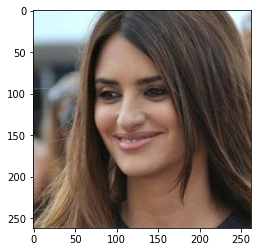

Actual age is 37
Predicted age using regression model is 38.9515380859375
Predicted age group using classification model is 25-50 with probability of 54.54%


In [10]:
plt.imshow(imgOG)
plt.show()

filename = os.path.split(img_path)[1]
broj_god = int(filename.split('.')[0].split('_')[2]) - int(filename.split('_')[1].split('-')[0])

clf_prediction_max = max(clf_prediction[0])
prob = clf_prediction_max   # clf_prediction_max = 0.78 zapravo kaze da sa vjerojatnoscu od 78% pripadamo 0. klasi (0-25 god)
prob = prob*100
maxIndex = np.where(clf_prediction[0] == clf_prediction_max)
predicted_class = str(int(maxIndex[0][0])*25) + '-' + str(int(maxIndex[0][0]+1)*25)

print(f'Actual age is {broj_god}')
print(f'Predicted age using regression model is {reg_prediction[0][0]}')
print(f'Predicted age group using classification model is {predicted_class} with probability of {round(prob,2)}%')